<div class="alert alert-warning">
<b>注意：</b>
<p>由于网络原因下面代码务必在自己的电脑上运行</p>
</div>

#### 检查 GPU 的状态和性能

执行一下命令可以看到 NVIDIA GPU（图形处理单元）的状态和性能

In [ ]:
!nvidia-smi

# CLIP模型调用
![CLIP模型训练示意图](img/clip1.jpg)

In [32]:
from transformers import CLIPProcessor,CLIPModel

In [38]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

## CLIP做Zero-shot prediction
![CLIP做开集图像识别示意图](img/clip2.jpg)

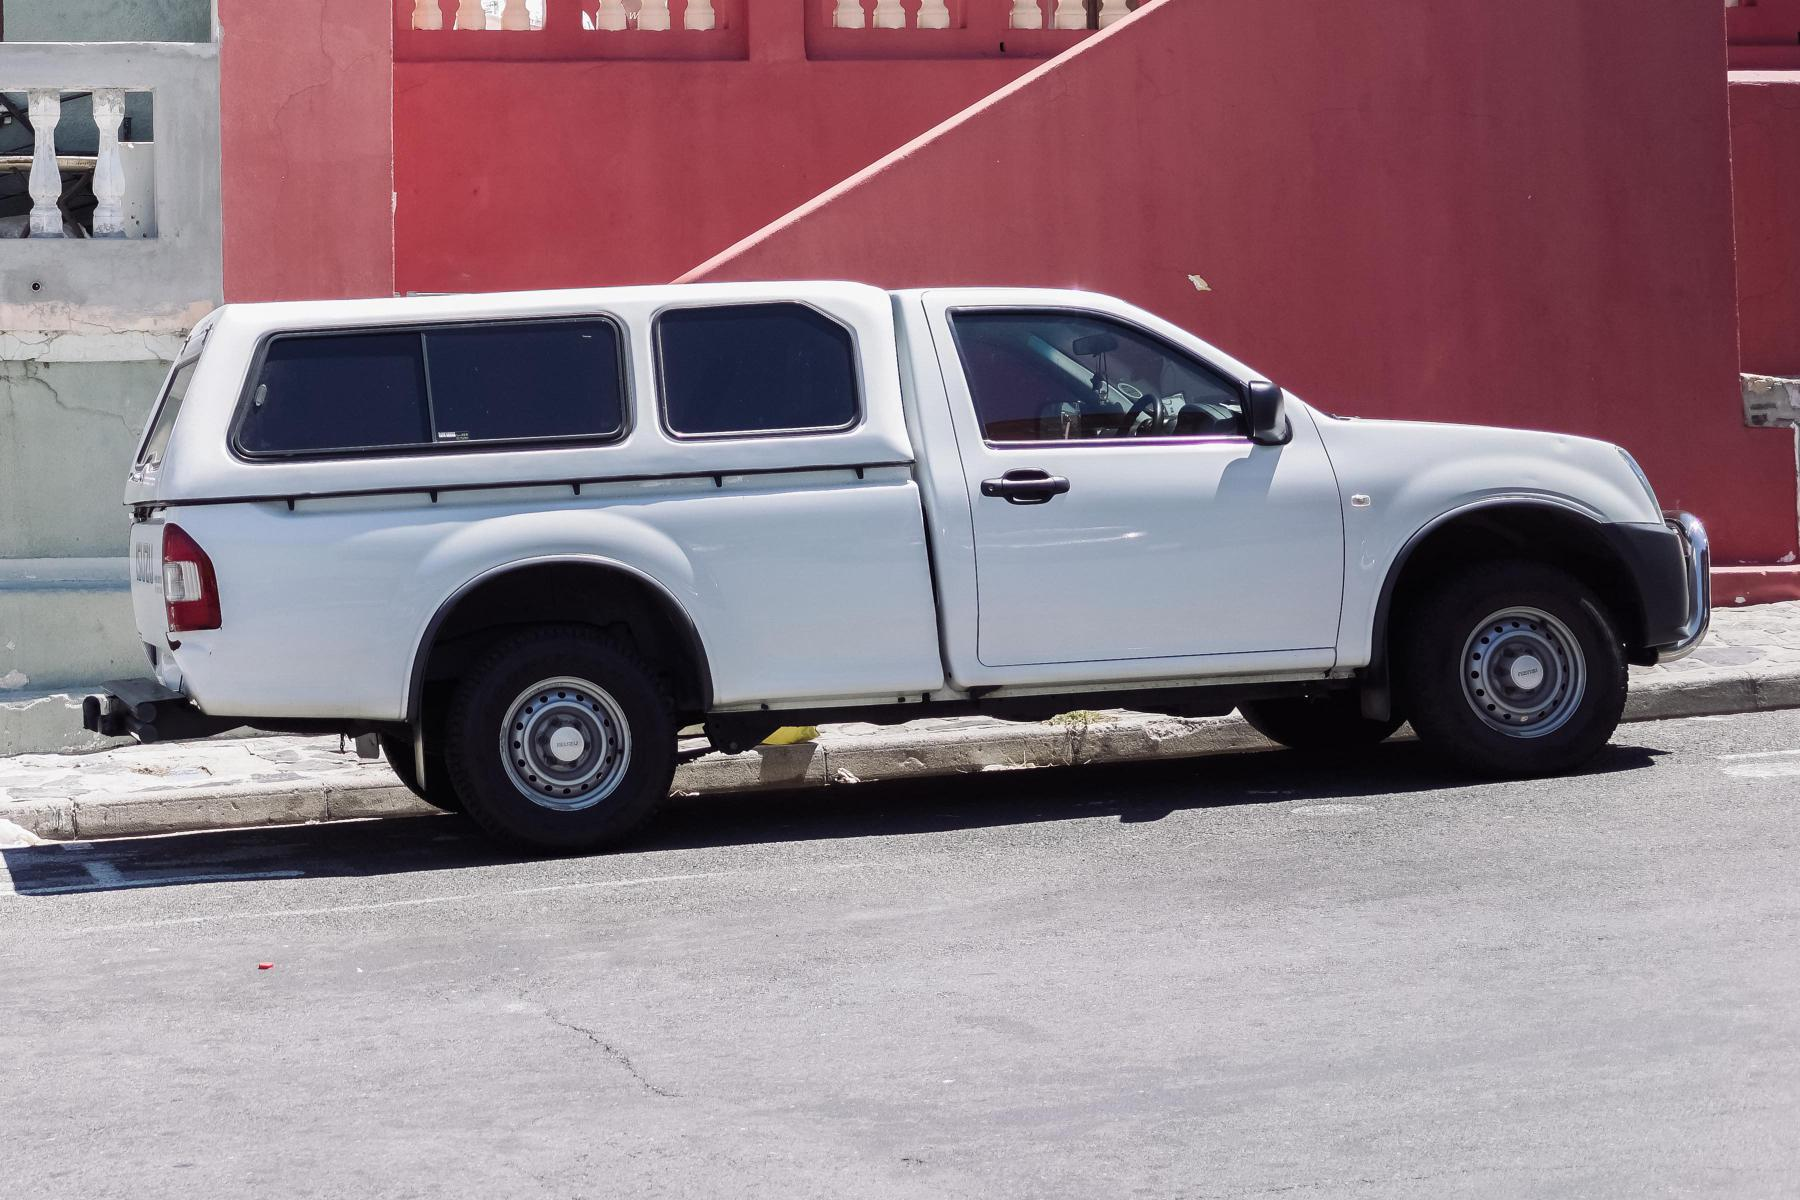

In [34]:
from IPython.display import Image, display
display(Image(filename="data_examples/truck.jpg"))

In [35]:
from PIL import Image
image = Image.open("data_examples/truck.jpg")
cls_list = ["dog", "woman", "man", "car", "truck", "a black truck", "a white truck", "cat"]
input = processor(text=cls_list, images=image, return_tensors="pt", padding=True)
outputs = model(**input)
print(outputs.keys())

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])


CLIP模型反馈的结果包含['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'] 这六组结果，分别对应：

- `logits_per_image`: 每个图像于cls_list中所有文本标签的相似度；[1x7]
- `logits_per_text`: logits_per_image的矩阵转置 `logits_per_text = logits_per_image.t()`
- `text_embeds`: 每个文本标签对应的特征矩阵
- `image_embeds`: 每个图像对应的特征矩阵
- `text_model_output`: 文本模型（未经过）特征映射的输出
- `vision_model_output`: 图像模型（未经过）特征映射的输出

In [36]:
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

for i in range(len(cls_list)):
    print(f"{cls_list[i]}: {probs[0][i]}")

dog: 4.405536310514435e-05
woman: 3.664955875137821e-05
man: 0.0002588978677522391
car: 0.013573568314313889
truck: 0.06473302841186523
a black truck: 0.02343929372727871
a white truck: 0.8979105353355408
cat: 3.939394446206279e-06


# 中文CLIP模型

[Chinese-CLIP](https://github.com/OFA-Sys/Chinese-CLIP)

> 本项目为CLIP模型的中文版本，使用大规模中文数据进行训练（~2亿图文对），旨在帮助用户快速实现中文领域的图文特征&相似度计算、跨模态检索、零样本图片分类等任务。本项目代码基于open_clip project建设，并针对中文领域数据以及在中文数据上实现更好的效果做了优化。本项目提供了API、训练代码和测试代码，下文中将详细介绍细节。

In [1]:
%pip install cn_clip

Note: you may need to restart the kernel to use updated packages.


In [18]:
import cn_clip.clip as clip
from PIL import Image
from cn_clip.clip import load_from_name, available_models
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Available models:", available_models())  
# Available models: ['ViT-B-16', 'ViT-L-14', 'ViT-L-14-336', 'ViT-H-14', 'RN50']

Available models: ['ViT-B-16', 'ViT-L-14', 'ViT-L-14-336', 'ViT-H-14', 'RN50']


`B` 代表 Big，`L`代表 Large, `H`代表 Huge;
B L H 后面紧跟的数字代表图像patch化时，每个patch的分辨率大小，14代表图像是按照14x14的分辨率被划分成相互没有overlap的图像块。
-336 表示，输入图像被resize到336x336分辨率后进行的处理；默认是224x224的分辨率。
RN50 表示ResNet50

In [27]:
model, preprocess = load_from_name("ViT-B-16", device=device, download_root='./')
model.eval()

image = preprocess(Image.open("data_examples/truck.jpg")).unsqueeze(0).to(device)
cls_list = ["狗", "汽车", "卡车", "白色的皮卡", "黑色的皮卡"]
text = clip.tokenize(cls_list).to(device)

Loading vision model config from /opt/conda/lib/python3.11/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /opt/conda/lib/python3.11/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}


In [37]:
import torch 

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    # 对特征进行归一化，请使用归一化后的图文特征用于下游任务
    image_features /= image_features.norm(dim=-1, keepdim=True) 
    text_features /= text_features.norm(dim=-1, keepdim=True)    

    logits_per_image, logits_per_text = model.get_similarity(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

from IPython.display import Image, display
display(Image(filename="data_examples/truck.jpg"))
for i in range(len(cls_list)):
    print(f"{cls_list[i]}: {probs[0][i]}")

AttributeError: 'CLIPModel' object has no attribute 'encode_image'